In [ ]:
import shap 
import sklearn 
import itertools
import pydotplus
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from IPython.display import Image 
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer,SimpleImputer 
from util import load_data,cindex

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).


In [ ]:
!pip install shap

In [ ]:
!pip install lifelines

In [ ]:
x_dev,x_test,y_dev,y_test = load_data(10)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
x_train,x_val,y_train,y_val = train_test_split(x_dev,y_dev,test_size=0.25,random_state=10)

In [ ]:
print("x_train shape: {}".format(x_train.shape))
x_train.head()

x_train shape: (5147, 18)


,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
1599,43.0,84.0,637.0,1.0,49.3,10.0,5.0,253.0,134.0,1.59,7.7,1.0,NaN,490.0,27.3,9.1,25.803007,34.0
2794,72.0,96.0,154.0,2.0,43.4,23.0,4.3,265.0,106.0,1.66,6.8,2.0,208.0,301.0,35.2,6.0,33.394319,112.0
1182,54.0,78.0,205.0,1.0,43.8,12.0,4.2,206.0,180.0,1.67,6.6,2.0,NaN,363.0,49.6,5.9,20.278410,34.0
6915,59.0,90.0,417.0,1.0,43.4,9.0,4.5,327.0,114.0,1.65,7.6,2.0,NaN,347.0,32.9,6.1,32.917744,78.0
500,34.0,80.0,385.0,1.0,77.7,9.0,4.1,197.0,64.0,1.74,7.3,2.0,NaN,376.0,17.0,8.2,30.743489,30.0


In [ ]:
y_train.head()

1599    False
2794     True
1182    False
6915    False
500     False
Name: time, dtype: bool

In [ ]:
i = 20 
print(x_train.iloc[i,:])
print("\n dies within 10 years {}".format(y_train.loc[y_train.index[i]]))

Age                    27.000000
Diastolic BP           68.000000
Poverty index         257.000000
Race                    1.000000
Red blood cells        41.500000
Sedimentation rate     35.000000
Serum Albumin           4.800000
Serum Cholesterol     247.000000
Serum Iron            194.000000
Serum Magnesium         1.470000
Serum Protein           7.100000
Sex                     2.000000
Systolic BP                  NaN
TIBC                  504.000000
TS                     38.500000
White blood cells       6.900000
BMI                    22.627747
Pulse pressure         52.000000
Name: 7804, dtype: float64

 dies within 10 years False


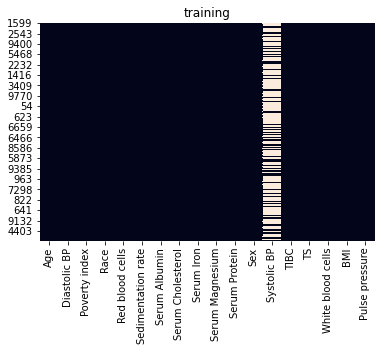

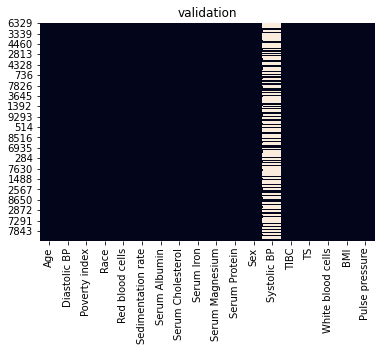

In [ ]:
sns.heatmap(x_train.isnull(),cbar=False)
plt.title("training")
plt.show()
sns.heatmap(x_val.isnull(),cbar=False)
plt.title("validation")
plt.show()

In [ ]:
def fraction_rows_missing(df):
  return np.sum(pd.DataFrame.any(df.isnull(),axis=1)) / df.shape[0]

In [ ]:
print(f"fraction of rows missing from x_train: {fraction_rows_missing(x_train):.3f}")
print(f"fraction of rows missing from x_train: {fraction_rows_missing(x_val):.3f}")
print(f"fraction of rows missing from x_train: {fraction_rows_missing(x_test):.3f}")

fraction of rows missing from x_train: 0.699
fraction of rows missing from x_train: 0.704
fraction of rows missing from x_train: 0.000


In [ ]:
x_train_dropped = x_train.dropna(axis='rows')
y_train_dropped = y_train.loc[x_train_dropped.index]
x_val_dropped = x_val.dropna(axis='rows')
y_val_dropped = y_val.loc[x_val_dropped.index]

In [ ]:
dt = DecisionTreeClassifier(max_depth=None,random_state=10)
dt.fit(x_train_dropped,y_train_dropped)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=10, splitter='best')

In [ ]:
y_train_preds = dt.predict_proba(x_train_dropped)[:,1]
print(f"train c index: {cindex(y_train_dropped.values,y_train_preds)}")
y_val_preds = dt.predict_proba(x_val_dropped)[:, 1]
print(f"Val C-Index: {cindex(y_val_dropped.values, y_val_preds)}")

train c index: 1.0
Val C-Index: 0.5629321808510638


In [ ]:
dt_hyperparams = {
    'max_depth':20,
    'min_samples_split': 0.5
}

In [ ]:
dt_reg = DecisionTreeClassifier(**dt_hyperparams,random_state=10)
dt_reg.fit(x_train_dropped,y_train_dropped)
y_train_preds = dt_reg.predict_proba(x_train_dropped)[:, 1]
y_val_preds = dt_reg.predict_proba(x_val_dropped)[:, 1]
print(f"Train C-Index: {cindex(y_train_dropped.values, y_train_preds)}")
print(f"Val C-Index (expected > 0.6): {cindex(y_val_dropped.values, y_val_preds)}")

Train C-Index: 0.6201372530835575
Val C-Index (expected > 0.6): 0.6116855053191489


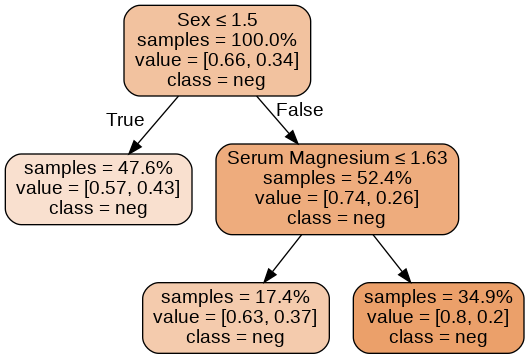

In [ ]:
dot_data = StringIO()
export_graphviz(dt_reg,feature_names=x_train_dropped.columns,out_file = dot_data,filled=True,rounded=True,proportion=True,special_characters=True,impurity=False,class_names=["neg","pos"],precision=2)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [ ]:
rf = RandomForestClassifier(n_estimators=100,random_state=10)
rf.fit(x_train_dropped,y_train_dropped)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [ ]:
y_train_rf_preds = rf.predict_proba(x_train_dropped)[:, 1]
print(f"Train C-Index: {cindex(y_train_dropped.values, y_train_rf_preds)}")
y_val_rf_preds = rf.predict_proba(x_val_dropped)[:, 1]
print(f"Val C-Index: {cindex(y_val_dropped.values, y_val_rf_preds)}")

Train C-Index: 1.0
Val C-Index: 0.6660488696808511


In [ ]:
'''
The hyperparameters we choose to adjust will be:

    n_estimators: the number of trees used in the forest.
    max_depth: the maximum depth of each tree.
    min_samples_leaf: the minimum number (if int) or proportion (if float) of samples in a leaf.

The approach we implement to tune the hyperparameters is known as a grid search:

    We define a set of possible values for each of the target hyperparameters.

    A model is trained and evaluated for every possible combination of hyperparameters.

    The best performing set of hyperparameters is returned.


In [ ]:
def holdout_grid_search(clf,x_train_hp,y_train_hp,x_val_hp,y_val_hp,hyperparams,fixed_hyperparams={}):
  best_estimator = None
  best_hyperparams = {}
  best_score = 0.0
  lists = hyperparams.values()
  param_combinations = list(itertools.product(*lists))
  total_param_combinations = len(param_combinations)
  for i,params in enumerate(param_combinations,1):
    param_dict = {}
    for param_index,param_name in enumerate(hyperparams):
      param_dict[param_name] = params[param_index]
    estimator = clf(**param_dict,**fixed_hyperparams)
    estimator.fit(x_train_hp,y_train_hp)
    preds = estimator.predict_proba(x_val_hp)
    estimator_score = cindex(y_val_hp,preds[:,1])
    print(f'[{i}/{total_param_combinations}] {param_dict}')
    print(f'Val C-Index: {estimator_score}\n')
    if estimator_score >= best_score:
      best_score = estimator_score
      best_estimator = estimator
      best_hyperparams = param_dict
  best_hyperparams.update(fixed_hyperparams)
  return best_estimator,best_hyperparams


In [ ]:
def random_forest_grid_search(x_train_dropped,y_train_dropped,x_val_dropped,y_val_dropped):
  hyperparams = {
      'n_estimators': [10],
      'max_depth' : [5],
      'min_samples_leaf' : [1]
  }
  fixed_hyperparams = {
      'random_state':10
  }
  rf = RandomForestClassifier
  best_rf,best_hyperparams = holdout_grid_search(rf, x_train_dropped, y_train_dropped,
                                                    x_val_dropped, y_val_dropped, hyperparams,
                                                    fixed_hyperparams)
  print(f"Best hyperparameters:\n{best_hyperparams}")
  y_train_best = best_rf.predict_proba(x_train_dropped)[:, 1]
  print(f"Train C-Index: {cindex(y_train_dropped, y_train_best)}")
  y_val_best = best_rf.predict_proba(x_val_dropped)[:, 1]
  print(f"Val C-Index: {cindex(y_val_dropped, y_val_best)}")
  best_hyperparams.update(fixed_hyperparams)
  return best_rf, best_hyperparams

In [ ]:
best_rf, best_hyperparams = random_forest_grid_search(x_train_dropped, y_train_dropped, x_val_dropped, y_val_dropped)

[1/1] {'n_estimators': 10, 'max_depth': 5, 'min_samples_leaf': 1}
Val C-Index: 0.6594414893617021

Best hyperparameters:
{'n_estimators': 10, 'max_depth': 5, 'min_samples_leaf': 1, 'random_state': 10}
Train C-Index: 0.8051024761198182
Val C-Index: 0.6594414893617021


In [ ]:
y_test_best = best_rf.predict_proba(x_test)[:, 1]
print(f"Test C-Index: {cindex(y_test.values, y_test_best)}")

Test C-Index: 0.687428800472554


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


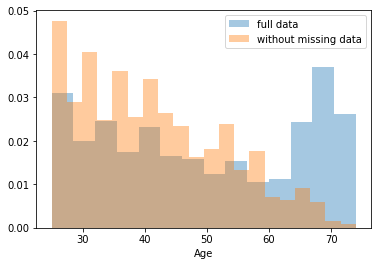

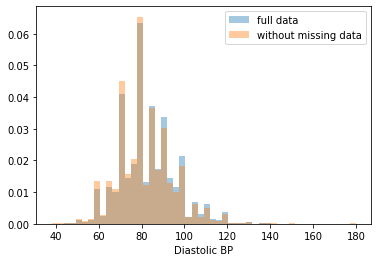

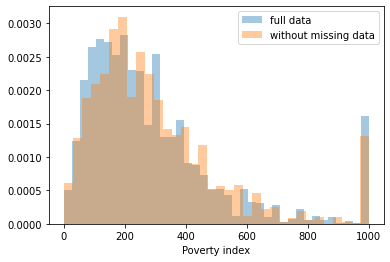

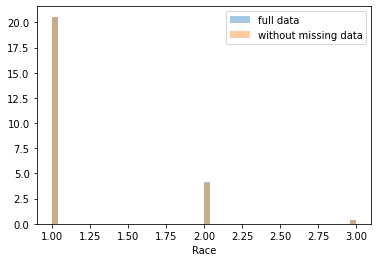

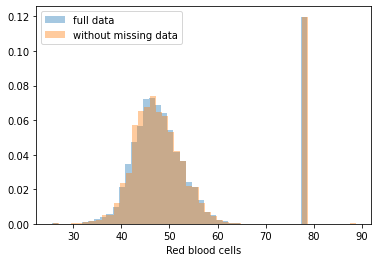

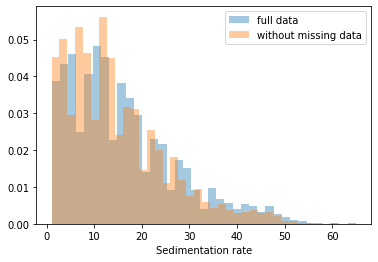

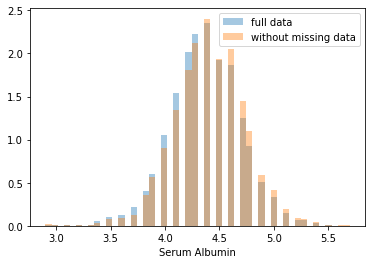

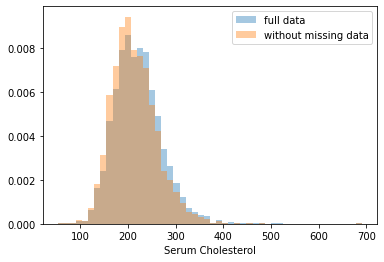

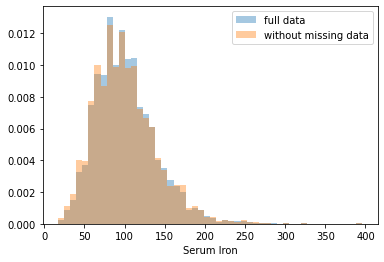

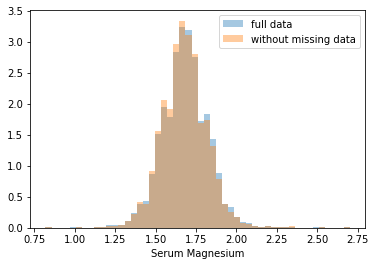

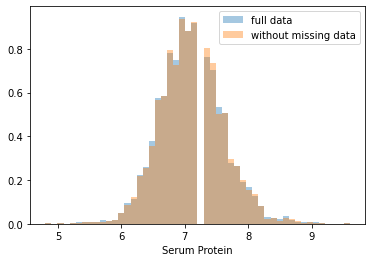

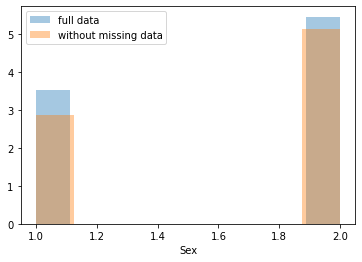

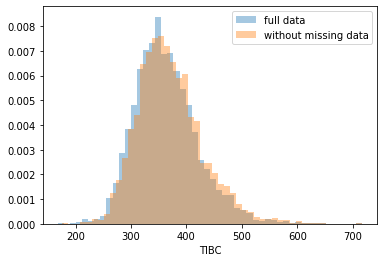

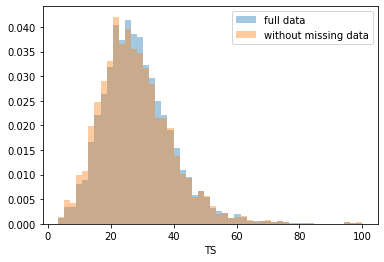

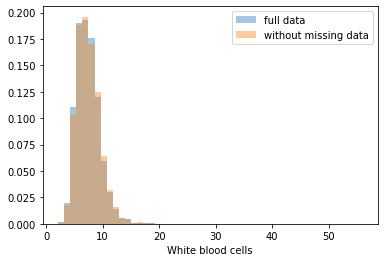

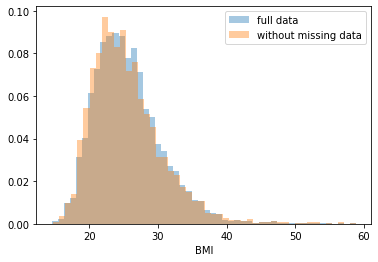

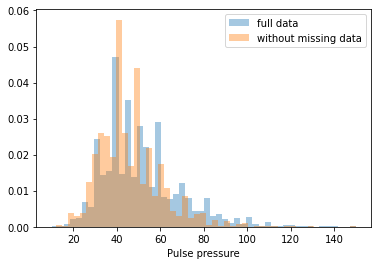

In [ ]:
dropped_rows = x_train[x_train.isnull().any(axis=1)]

columns_except_Systolic_BP = [col for col in x_train.columns if col not in ['Systolic BP']]

for col in columns_except_Systolic_BP:
    sns.distplot(x_train.loc[:, col], norm_hist=True, kde=False, label='full data')
    sns.distplot(dropped_rows.loc[:, col], norm_hist=True, kde=False, label='without missing data')
    plt.legend()
    plt.show()

In [ ]:
'''
Most of the covariates are distributed similarly whether or not we have discarded rows with missing data. In other words missingness of the data is independent of these covariates.

If this had been true across all covariates, then the data would have been said to be missing completely at random (MCAR).

But when considering the age covariate, we see that much more data tends to be missing for patients over 65. The reason could be that blood pressure was measured less frequently for old people to avoid placing additional burden on them.

As missingness is related to one or more covariates, the missing data is said to be missing at random (MAR).

Based on the information we have, there is however no reason to believe that the values of the missing data — or specifically the values of the missing systolic blood pressures — are related to the age of the patients. If this was the case, then this data would be said to be missing not at random (MNAR).


In [ ]:
def bad_subset(forest, X_test, y_test):
    mask = X_test['BMI'] < 32
    X_subgroup = X_test[mask]
    y_subgroup = y_test[mask]
    subgroup_size = len(X_subgroup)

    y_subgroup_preds = forest.predict_proba(X_subgroup)[:, 1]
    performance = cindex(y_subgroup.values, y_subgroup_preds)
    
    return performance, subgroup_size

In [ ]:
performance, subgroup_size = bad_subset(best_rf, x_test, y_test)
print("Subgroup size should greater than 250, performance should be less than 0.69 ")
print(f"Subgroup size: {subgroup_size}, C-Index: {performance}")

Subgroup size should greater than 250, performance should be less than 0.69 
Subgroup size: 1549, C-Index: 0.6862200048138807


In [ ]:
imputer = SimpleImputer(strategy='mean')
imputer.fit(x_train)
X_train_mean_imputed = pd.DataFrame(imputer.transform(x_train), columns=x_train.columns)
X_val_mean_imputed = pd.DataFrame(imputer.transform(x_val), columns=x_val.columns)

In [ ]:
hyperparams = {
    'n_estimators': [10],
    'max_depth': [4],
    'min_samples_leaf': [1],
}

In [ ]:
rf = RandomForestClassifier

rf_mean_imputed, best_hyperparams_mean_imputed = holdout_grid_search(rf, X_train_mean_imputed, y_train,
                                                                     X_val_mean_imputed, y_val,
                                                                     hyperparams, {'random_state': 10})

print("Performance for best hyperparameters:")
y_train_best = rf_mean_imputed.predict_proba(X_train_mean_imputed)[:, 1]
print(f"- Train C-Index: {cindex(y_train, y_train_best):.4f}")
y_val_best = rf_mean_imputed.predict_proba(X_val_mean_imputed)[:, 1]
print(f"- Val C-Index: {cindex(y_val, y_val_best):.4f}")
y_test_imp = rf_mean_imputed.predict_proba(x_test)[:, 1]
print(f"- Test C-Index: {cindex(y_test, y_test_imp):.4f}")

[1/1] {'n_estimators': 10, 'max_depth': 4, 'min_samples_leaf': 1}
Val C-Index: 0.7404248065853272

Performance for best hyperparameters:
- Train C-Index: 0.7765
- Val C-Index: 0.7404
- Test C-Index: 0.7788


In [ ]:
imputer = IterativeImputer(random_state=0, sample_posterior=False, max_iter=1, min_value=0)
imputer.fit(x_train)
X_train_imputed = pd.DataFrame(imputer.transform(x_train), columns=x_train.columns)
X_val_imputed = pd.DataFrame(imputer.transform(x_val), columns=x_val.columns)

[IterativeImputer] Early stopping criterion not reached.


In [ ]:
hyperparams = {
    'n_estimators': [10],
    'max_depth': [4],
    'min_samples_leaf': [1],
}

In [ ]:
rf = RandomForestClassifier
rf_imputed, best_hyperparams_imputed = holdout_grid_search(rf, X_train_imputed, y_train,
                                                           X_val_imputed, y_val,
                                                           hyperparams, {'random_state': 10})
print("Performance for best hyperparameters:")
y_train_best = rf_imputed.predict_proba(X_train_imputed)[:, 1]
print(f"- Train C-Index: {cindex(y_train, y_train_best):.4f}")
y_val_best = rf_imputed.predict_proba(X_val_imputed)[:, 1]
print(f"- Val C-Index: {cindex(y_val, y_val_best):.4f}")
y_test_imp = rf_imputed.predict_proba(x_test)[:, 1]
print(f"- Test C-Index: {cindex(y_test, y_test_imp):.4f}")

[1/1] {'n_estimators': 10, 'max_depth': 4, 'min_samples_leaf': 1}
Val C-Index: 0.7332560326052734

Performance for best hyperparameters:
- Train C-Index: 0.7768
- Val C-Index: 0.7333
- Test C-Index: 0.7678


In [ ]:
performance, subgroup_size = bad_subset(best_rf, x_test, y_test)
print(f"C-Index (no imputation): {performance}")
performance, subgroup_size = bad_subset(rf_mean_imputed, x_test, y_test)
print(f"C-Index (mean imputation): {performance}")
performance, subgroup_size = bad_subset(rf_imputed, x_test, y_test)
print(f"C-Index (multivariate feature imputation): {performance}")

C-Index (no imputation): 0.6862200048138807
C-Index (mean imputation): 0.7793437424783114
C-Index (multivariate feature imputation): 0.7662023713595028


In [ ]:
#We should see that avoiding complete case analysis (i.e. analysis only on observations for which there is no missing data)
#allows our model to generalize a bit better. Remember to examine your missing cases to judge whether they are missing at random or not!

In [ ]:
'''
Using a random forest has improved results, but we've lost some of the natural interpretability of trees.
 In this section we'll try to explain the predictions using slightly more sophisticated techniques. 
 You choose to apply *SHAP (SHapley Additive exPlanations) *, a cutting edge method that explains predictions made by
 black-box machine learning models (i.e. models which are too complex to be understandable by humans as is).
 Given a prediction made by a machine learning model, SHAP values explain the prediction by
  quantifying the additive importance of each feature to the prediction. SHAP values have their roots in cooperative game theory, 
 where Shapley values are used to quantify the contribution of each player to the game.
 

In [ ]:
X_test_risk = x_test.copy(deep=True)
X_test_risk.loc[:, 'risk'] = rf_imputed.predict_proba(X_test_risk)[:, 1]
X_test_risk = X_test_risk.sort_values(by='risk', ascending=False)
X_test_risk.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,risk
1017,65.0,98.0,16.0,1.0,49.4,30.0,3.4,124.0,129.0,1.59,7.7,1.0,184.0,293.0,44.0,5.9,30.858853,86.0,0.653968
5493,67.0,80.0,30.0,1.0,77.7,59.0,3.4,231.0,36.0,1.40,6.3,1.0,170.0,202.0,17.8,8.4,17.029470,90.0,0.649964
5954,67.0,70.0,134.0,1.0,77.7,57.0,3.3,120.0,42.0,1.47,6.4,2.0,120.0,318.0,13.2,8.8,17.612034,50.0,0.599147
2050,66.0,100.0,69.0,2.0,42.9,47.0,3.8,233.0,170.0,1.42,8.6,1.0,180.0,411.0,41.4,7.2,22.129498,80.0,0.596960
2100,61.0,86.0,130.0,1.0,40.0,55.0,3.8,207.0,76.0,1.53,10.2,2.0,180.0,367.0,20.7,7.4,36.311983,94.0,0.594056


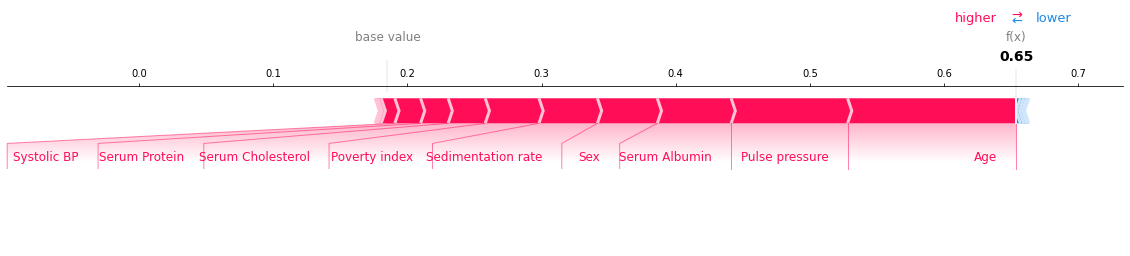

In [ ]:
explainer = shap.TreeExplainer(rf_imputed)
i = 0
shap_value = explainer.shap_values(x_test.loc[X_test_risk.index[i], :])[1]
shap.force_plot(explainer.expected_value[1], shap_value, feature_names=x_test.columns, matplotlib=True)

How to read this chart:
- The red sections on the left are features which push the model towards the final prediction in the positive direction (i.e. a higher Age increases the predicted risk).
- The blue sections on the right are features that push the model towards the final prediction in the negative direction (if an increase in a feature leads to a lower risk, it will be shown in blue).
- Note that the exact output of your chart will differ depending on the hyper-parameters that you choose for your model.

We can also use SHAP values to understand the model output in aggregate. Run the next cell to initialize the SHAP values (this may take a few minutes).

In [ ]:
shap_values = shap.TreeExplainer(rf_imputed).shap_values(x_test)[1]

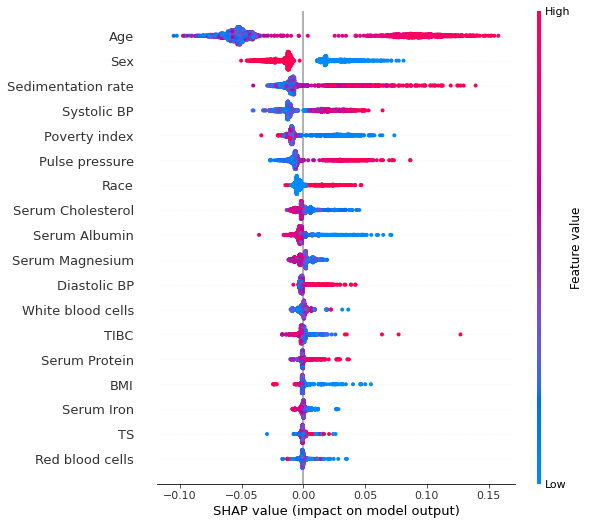

In [ ]:
shap.summary_plot(shap_values, x_test)

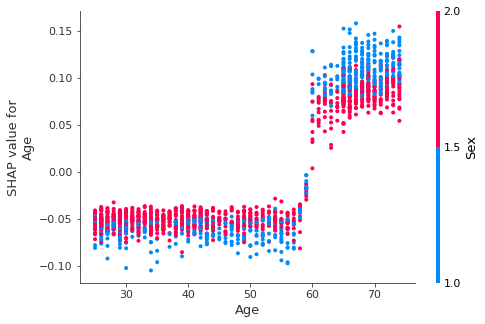

In [ ]:
shap.dependence_plot('Age', shap_values, x_test, interaction_index='Sex')

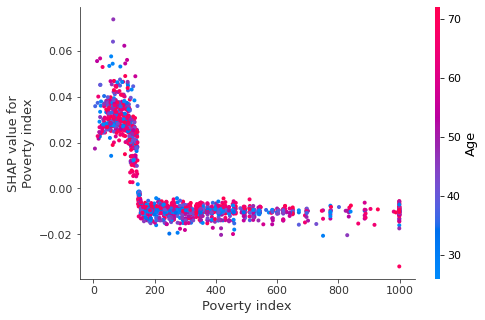

In [ ]:
shap.dependence_plot('Poverty index', shap_values, x_test, interaction_index='Age')